<a href="https://colab.research.google.com/github/raj3000k/traffic-prediction/blob/main/Test_Traffic_prediction_using_RNN%2C_GRU_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout,GRU
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# @title
path ='/content/traffic.csv'
data = pd.read_csv(path,index_col = 'DateTime')
data.head()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [ ]:
# @title
data.shape


(48120, 3)

In [ ]:
# @title
data.dtypes

Junction    int64
Vehicles    int64
ID          int64
dtype: object

In [ ]:
# @title
data = data[data['Junction']==2]

In [ ]:
# @title
data.isnull().sum()/data.count()*100

Junction    0.0
Vehicles    0.0
ID          0.0
dtype: float64

In [ ]:
# @title
def last_n_days(df, feature, n_days):
    """
    Extract last n_days of a time series
    """

    return df[feature][-(24*n_days):]

def plot_last_n_days(df, feature, n_days):
    """
    Plot last n_days of an hourly time series
    """
    plt.figure(figsize = (40,10))
    plt.plot(last_n_days(df, feature, n_days), 'k-')
    plt.title('{0} Time Series - {1} days'
              .format(feature, n_days))
    plt.xlabel('Recorded hour')
    plt.ylabel('No.Of Vehicles')
    plt.grid(alpha=0.3)

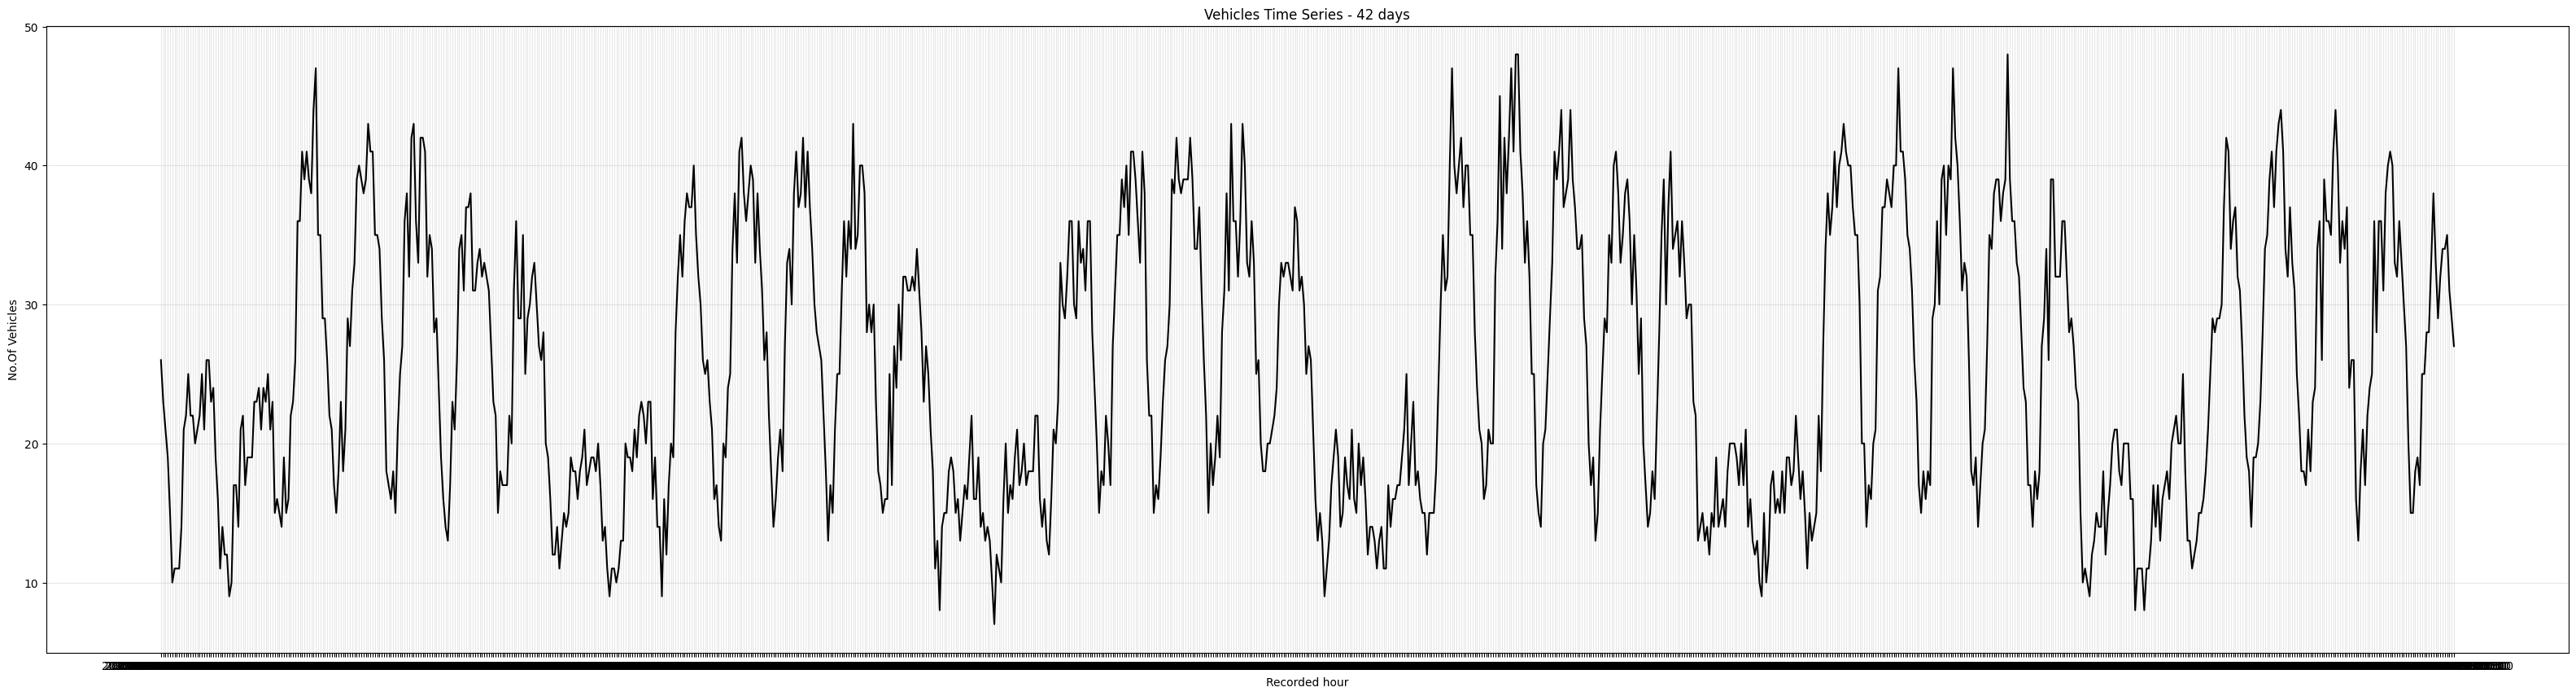

In [ ]:
# @title
plot_last_n_days(data, 'Vehicles', 42)


In [ ]:
# @title
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape
    [n_samples, time_steps, features]
    """

    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours,
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into
    train and test with keras-friendly format, according to user-specified
    choice of shape.

    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5

    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y
    """

    forecast_series = last_n_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap.
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap):
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras

    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours]
    test_y = test[input_hours:] # test_y is remaining values from test set

    return train_X, test_X_init, train_y, test_y

In [ ]:
# @title
series_days=int(input("Enter Series days:"))
input_hours= int(input("Enter Input hours:"))
test_hours= int(input("Enter Test hours:"))


train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(data, 'Vehicles', series_days,
                         input_hours, test_hours))

Enter Series days:60
Enter Input hours:20
Enter Test hours:24


In [ ]:
# @title
train_y.shape


(466,)

In [ ]:
# @title
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (466, 20, 1)
Training output shape: (466,)
Test input shape: (20,)
Test output shape: (4,)


In [ ]:
# @title
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y

    arguments
    ---------
    train_X (array): input sequence samples for training
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells
    epochs (int): number of training epochs
    """
    model = Sequential()


    # # construct an RNN layer with specified number of hidden units
    # # per cell and desired sequence input format
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))

    # # add an output layer to make final predictions
    model.add(Dense(1))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    train_predictions = model.predict(train_X)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(train_y, train_predictions))
    mean_actual = np.mean(train_y)
    percentage_error = (rmse / mean_actual) * 100
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Percentage Error:", percentage_error)



    return model

In [ ]:
# @title
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)


15/15 [==============================] - 0s 1ms/step
Root Mean Squared Error (RMSE): 25.591020791234463
Percentage Error: 100.52613747547214


In [ ]:
# @title
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series
    """

    X_init = X_init.copy().reshape(1,-1,1)
    preds = []

    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction

    preds = np.array(preds).reshape(-1,1)

    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps

    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title
    """

    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours

    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')

    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

15/15 [==============================] - 0s 2ms/step
Root Mean Squared Error (RMSE): 1.8715609639772
Percentage Error: 7.351828451600567
1/1 [==============================] - 0s 14ms/step


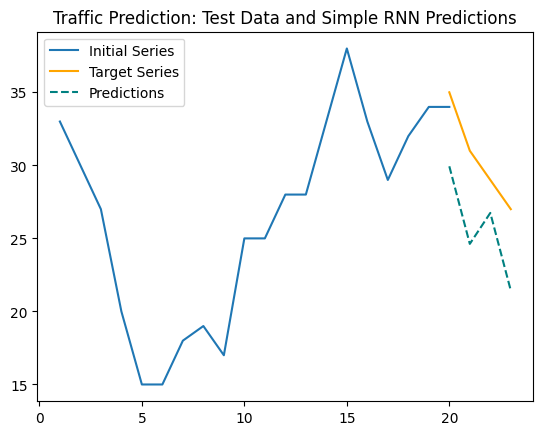

In [ ]:
# @title
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=3000)
predict_and_plot(test_X_init, test_y, model,
                 'Traffic Prediction: Test Data and Simple RNN Predictions')

In [ ]:
# @title
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 30)                960       
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 991 (3.87 KB)
Trainable params: 991 (3.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def fit_GRU(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y

    arguments
    ---------
    train_X (array): input sequence samples for training
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells
    epochs (int): number of training epochs
    """

    # initialize model
    model = Sequential()
    model.add(GRU(64, input_shape=(input_hours, 1), return_sequences=True))
    model.add(GRU(32))
    model.add(Dense(1))
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    train_predictions = model.predict(train_X)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(train_y, train_predictions))
    mean_actual = np.mean(train_y)
    percentage_error = (rmse / mean_actual) * 100
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Percentage Error:", percentage_error)

    return model

Enter Series days:60
Enter Input hours:12
Enter Test hours:24
15/15 [==============================] - 1s 3ms/step
Root Mean Squared Error (RMSE): 0.10307771334399843
Percentage Error: 0.4050749000335147
1/1 [==============================] - 0s 17ms/step


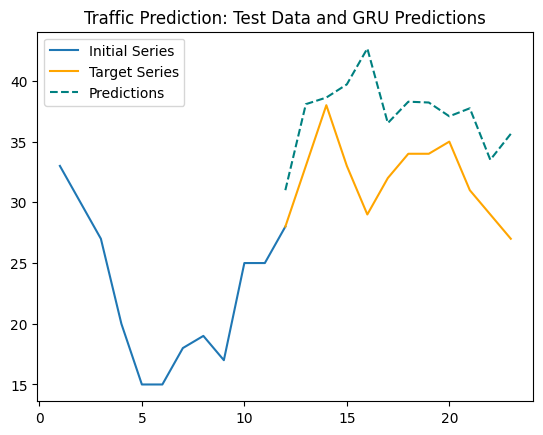

In [ ]:
series_days=int(input("Enter Series days:"))
input_hours= int(input("Enter Input hours:"))
test_hours= int(input("Enter Test hours:"))

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(data, 'Vehicles', series_days,
                         input_hours, test_hours))

model = fit_GRU(train_X, train_y, cell_units=40, epochs=3000)

predict_and_plot(test_X_init, test_y, model,
                 'Traffic Prediction: Test Data and GRU Predictions')

In [ ]:
# @title
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y

    arguments
    ---------
    train_X (array): input sequence samples for training
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells
    epochs (int): number of training epochs
    """

    # initialize model
    model = Sequential()

    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))

    # add an output layer to make final predictions
    model.add(Dense(1))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    train_predictions = model.predict(train_X)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(train_y, train_predictions))
    mean_actual = np.mean(train_y)
    percentage_error = (rmse / mean_actual) * 100
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Percentage Error:", percentage_error)

    return model

Enter Series days:90
Enter Input hours:12
Enter Test hours:48
22/22 [==============================] - 0s 2ms/step
Root Mean Squared Error (RMSE): 0.07515708112647929
Percentage Error: 0.30710382808087966
1/1 [==============================] - 0s 14ms/step


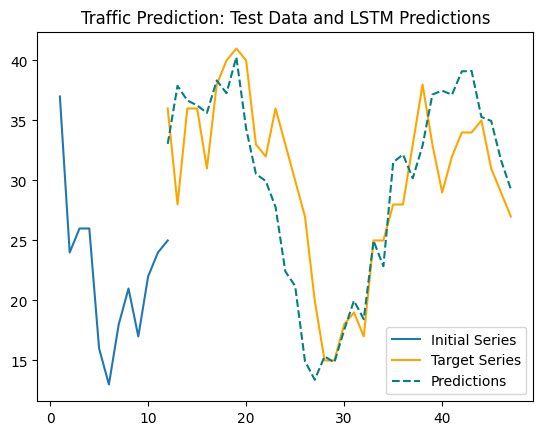

In [ ]:
# @title
series_days=int(input("Enter Series days:"))
input_hours= int(input("Enter Input hours:"))
test_hours= int(input("Enter Test hours:"))

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(data, 'Vehicles', series_days,
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000)

predict_and_plot(test_X_init, test_y, model,
                 'Traffic Prediction: Test Data and LSTM Predictions')

In [ ]:
# @title
